In [13]:
import torch
import os
from torch import linalg as LA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import math

print(torch.cuda.is_available())

True


In [14]:
device='cuda' 


# Define network parameters
W1 = torch.randn(20, 10, device=device, requires_grad=True)
b1 = torch.randn(20, 1, device=device, requires_grad=True)
W2 = torch.randn(20, 1, device=device, requires_grad=True)
b2 = torch.randn(1, device=device, requires_grad=True)

# Define forward pass function
def forward(x):
    z = torch.matmul(W1, x) + b1
    a = torch.tanh(z)
    y_hat = torch.matmul(W2.T, a) + b2
    return y_hat

# Define loss function
def loss(y_hat, y):
    return torch.mean(torch.abs(y_hat - y))

# Generate random input and output data
x = torch.randn(100, 10, 1, device=device)
y = torch.randn(100, 1, 1, device=device)

# Compute forward pass and loss
y_hat = forward(x)
L = loss(y_hat, y)

# Compute gradients with autograd
L.backward()
auto_W1 = W1.grad
auto_b1 = b1.grad
auto_W2 = W2.grad
auto_b2 = b2.grad

# Compute gradients manually
hand_b2 = torch.mean(torch.sign(y_hat - y), dim=0)
hand_W2 = torch.mean(torch.sign(y_hat - y) * torch.tanh(torch.matmul(W1, x) + b1), dim=0)
hand_b1 = torch.mean(torch.sign(y_hat - y) * W2 * (1 - torch.tanh(torch.matmul(W1, x) + b1) ** 2), dim=0)
hand_W1 = torch.mean(torch.matmul(torch.sign(y_hat - y) * W2 * (1 - torch.tanh(torch.matmul(W1, x) + b1) ** 2), x.permute(0, 2, 1)), dim=0)


# Compare gradients
print('W1 diff:', torch.linalg.norm(auto_W1 - hand_W1))
print('b1 diff:', torch.linalg.norm(auto_b1 - hand_b1))
print('W2 diff:', torch.linalg.norm(auto_W2 - hand_W2))
print('b2 diff:', torch.linalg.norm(auto_b2 - hand_b2))



RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [84]:
# Train this model on the sklearn California Housing Prices datasets.
# • For this you may use the optimizer and learning rates of your choice and train
# for 20-50 epochs.
# • Take half the data for training and half for testing.
# • Create a validation set from the training set and use it to select a good learning
# rate.
# • You might want to use the convenient Xavier initialization.
# • You are free to use the torch.optim package for this part.
# • To speed up things, run the training loop by batches (e.g. 4, 8, 32, 64, etc.).
# PyTorch’s DataLoader would be a useful tool to easily fetch a predefined set
# of batches per training iteration.
# • Report the mean squared error on the train and test set after each epoch.
# • You will need to adjust the size of W 1 to fit the size of this data.

# Load the data


data = fetch_california_housing()
X = data['data']
y = data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

# Convert to torch tensors
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Define the network
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.linear1 = torch.nn.Linear(8, 20)
        self.linear2 = torch.nn.Linear(20, 1)
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x
    
# Define the loss function
def my_loss(y_hat, y):
    return torch.mean(torch.abs(y_hat - y))

# Define the training loop
def train_loop(model, input, target, num_epochs=50, learning_rate=1e-3):
    for epoch in range(num_epochs):
        y_hat = forward(input)
        loss = my_loss(y_hat, target)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
                param.grad.zero_()
        if epoch % 5 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return model

# Train the network
model = MyNet().to(device)
model = train_loop(model, X_train, y_train)

# Evaluate the network
y_hat = model(X_test)
loss = my_loss(y_hat, y_test)
print('Test loss: %f' % loss)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x10 and 10320x8)

In [7]:
# question 2 
# Consider the neural network
# f(x) = WF ρ ◦ WL . . . ρ ◦ Wi . . . ρ ◦ W2ρ ◦ W1x
# where W1 is K × D, Wi
# is K × K for i > 1, and WF is P × K. Note f : RD → RP .
# Take ρ(x) = tanh(x). We will examine different ways to compute the Jacobian ∂f(x)/∂x .
# (a) 
# Use torch tensors to write a function which computes the Jacobian,
# ∂f(x)/∂x , using backward mode automatic differentiation for a given value of x and
# W1, . . . , Wi, . . . , WF where the given matrices are specified by a dictionary of torch
# tensors. Implement and test this for L = 3. Your function should only make use
# of basic matrix operations (e.g. torch.matmul(), torch.tanh(), etc). You may not
# use autograd or autograd.jacobian for your implementation (but you can use them
# to unit test your answer). Test it for the case of D = 2, K = 30, P = 10, your
# solution does not have to cover all edge cases of K, P,D it is sufficient it works on
# the ones provided here.

# Define the network
def my_nn(x, param_dict):
    for i in range(1, L):
        x = torch.matmul(param_dict['W' + str(i)], x)
        x = torch.tanh(x)
    x = torch.matmul(param_dict['WF'], x)
    return x

# Define the Jacobian function
def my_jacobian(x, param_dict):
    y = my_nn(x, param_dict) # forward pass
    J = torch.zeros(y.shape[0], x.shape[0])
    for i in range(y.shape[0]):
        y[i].backward(retain_graph=True)
        J[i, :] = x.grad
        x.grad.zero_()
    return J

# Define the parameters
D = 2
K = 30
P = 10
L = 10
param_dict = {}
param_dict['W1'] = torch.randn(K, D, device=device, requires_grad=True)
for i in range(2, L):
    param_dict['W' + str(i)] = torch.randn(K, K, device=device, requires_grad=True)
param_dict['WF'] = torch.randn(P, K, device=device, requires_grad=True)

# Define the input
x = torch.randn(D, device=device, requires_grad=True)

# Compute the Jacobian
J = my_jacobian(x, param_dict)
print(J)

# Compare with autograd
x = x.reshape(-1, 1)
y = my_nn(x, param_dict)
y = y.reshape(-1, 1)
J_autograd = torch.autograd.functional.jacobian(lambda x: my_nn(x, param_dict), x)
print(J)


RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

torch.Size([2])
torch.Size([30, 2])
torch.Size([30])
torch.Size([30, 30])
tensor([[-3.6832,  3.1388],
        [ 2.1358, -3.0074],
        [-5.7035,  3.5083],
        [ 4.5243, -3.9619],
        [ 3.4845, -4.2608],
        [-1.6215,  1.7399],
        [ 2.4567, -0.5928],
        [ 5.4941, -5.6483],
        [ 0.4993,  1.7094],
        [-5.2610,  3.5687]])


In [ ]:
# (c) (4 points) Benchmark the Jacobian computation of (b) compared to that of (c)
# for L=3,5,10. Report speed of these answers on test cases using GPU and CPU



/tmp/ipykernel_7772/3794295671.py:6: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x=torch.range(-1,2,0.1)


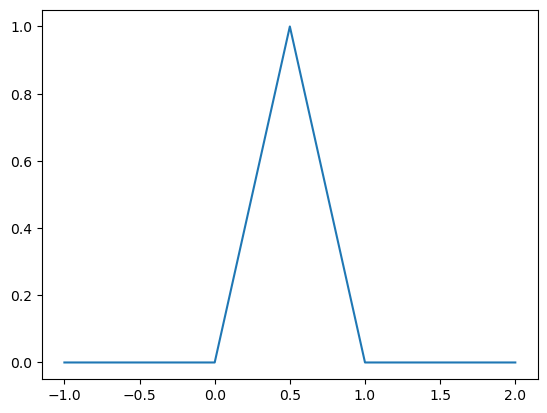

In [38]:
# 3(a)

def my_fun(x):
    return torch.relu(torch.relu(x*torch.tensor(2)) - torch.relu(x*torch.tensor(4) - torch.tensor(2)))

x=torch.range(-1,2,0.1)

plt.plot(x, my_fun(x))

# For the following functions find by hand the parameters of a neural network that can
# fit these functions. You should use either a 1 or 2 hidden layer network and may use
# either sigmoid or ReLU non-linearities. In each case justify your answer and how you
# arrived at it (without using numerical/software packages).


tensor([1.6800])


/tmp/ipykernel_7772/2001599451.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-5,5,0.1)


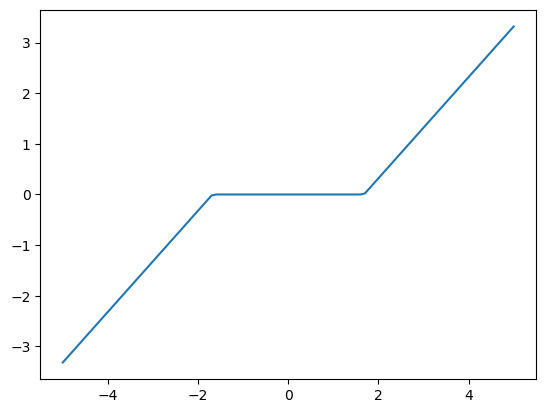

In [78]:
x = torch.range(-5,5,0.1)
s = torch.randn(1)
def my_fun(x, s):
    return torch.max(torch.abs(x) - s, torch.tensor([0.])) * torch.sign(x)

print(s)
plt.plot(x,my_fun(x, s))